# System Identification Simulations

## Example 3.5

In [1]:
import numpy as np
from scipy import linalg, signal
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
plt.rcParams.update({
    'font.family':'Times New Roman',
    # 'text.usetex': True
})
from LMS_algorithm import LMS

## 计算迭代步长

根据书87页，公式`(3.30)`的非简化表达式，计算

In [2]:
# spreed == 1
mu1 = 0.1
print('spread: %d' % (1,))
print('upper bound for mu is %.5f, when spreed=%02d' % (1 / (2+8), 1))

# spreed == 20
a = -0.6894 # 如何快速 reach， 或反解
r = [a**i for i in range(8)]
R = linalg.toeplitz(r)
D, V20 = linalg.eig(R)
D = abs(D)
print('spread: %d' % (max(D)/min(D)))
D20 = D
mu20 =  1 / (8 + 2 * max(D))
print('upper bound for mu is %.5f, when spreed=%d' % (mu20, 20))

# spreed == 80
a = -0.8702
r = [a**i for i in range(8)]
R = linalg.toeplitz(r)
D, V80 = linalg.eig(R)
D = abs(D)
print('spread: %d' % (max(D)/min(D)))
D80 = D
mu80 =  1 / (8 + 2 * max(D))
print('upper bound for mu is %.5f, when spreed=%d' % (mu80, 80))
print(D20)
print(D80)

spread: 1
upper bound for mu is 0.10000, when spreed=01
spread: 20
upper bound for mu is 0.06401, when spreed=20
spread: 80
upper bound for mu is 0.05119, when spreed=80
[3.811  1.7955 0.8814 0.51   0.3418 0.2572 0.2126 0.1905]
[5.7677 1.208  0.4215 0.2145 0.1359 0.0994 0.081  0.0721]


### 纠错

- 第四版英文书上112页的自相关矩阵给出的是错的。当 `AR` 模型的抽头系数放置在等号右侧时决定了，默认带有负号。
- 书中统一了复信号和实信号的更新方程系数为$2\mu$，而提供的`matlab`代码为$\mu$。
- 瞬态特性的迭代次数应该用幂函数拟合，对数运算可以克服。
- $(1-2\mu\lambda)^k = \dfrac{1}{100}$，故有 $k = -2 /\log10(1-2\mu\lambda)$，用$k = \max{\tau_{ei}} \times \ln(100)$ 偏差大，思维绕。

### 疑问

- 当 $a = 0.6894$时，其收敛步长的上界与 $a = -0.6894$相等。
- 当 $a = -0.6894$时，`AR` 模型为低通模型；反之，为高通模型。
- 高通模型，白噪声的输出噪声功率谱为衰减的；低通模型的输出功率谱是增长的。
- 两种白噪声驱动的色噪声中，高通的 `lms` 的收敛速度慢了一倍。
- 符号数据算法中，只关心数据的包络，尤其是复信号，尤为重要。
- 二元符号信号，不经过`AR` 滤波，spreed 为 $1$。

### TODO

- 特征值的闭式解。

## spreed=1

### 白噪声驱动信号

In [3]:
ensemble = 100  # number of realizations within the ensemble
K = 2000  # number of iterations
b = np.asarray([0.1, 0.3, 0, -0.2, -0.4, -0.7, -0.4, -0.2])
a = np.asarray([1, -0.6894])
N = 8

rng = np.random.default_rng()
sigma2_v = 1 - a[-1] ** 2
sigma2_n = 1e-4

# mse_min = mse = np.zeros((ensemble, K))
mse_min_expectation = sigma2_n

mse = []
wk_rec = []
mu = mu1 /5
for j in range(ensemble):
    ex35 = LMS()
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    x = signal.lfilter([1], [1], u)
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n) *rng.standard_normal(K)
    # x = 1/np.sqrt(2) * (np.sign(rng.standard_normal(K)) + 1J * np.sign(rng.standard_normal(K)))
    # d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n/2) * (rng.standard_normal(K) + 1J * rng.standard_normal(K))

    wk, ek = ex35.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

In [4]:
def plot_learning_curve(K):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    e2db_avg = 10 * np.log10(mse_avg)
    ax1.plot(e2db_avg)
    ax2.plot(np.real(wk_avg))
    ax2.grid(color='lightgrey', linestyle='-', linewidth=1)
    plt.tight_layout()
    ax1.set_title('Learning Curve for MSE')
    ax1.set_xlabel('Number of iterations, k')
    ax1.set_ylabel('MSE [dB]')
    ax1.set_xlim(0, K)
    ax2.set_xlim(0, K)
    plt.show()

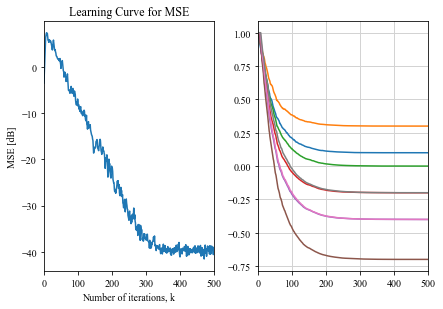

In [5]:
plot_learning_curve(500)

In [6]:
xi = np.mean(mse_avg[-500:])/1e-4-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N*sigma2_v/(1-mu*N*sigma2_v)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)
print('approx number of iterations: %d ' % (-2/np.log10(1-2*mu*sigma2_v)))

experiment Misadjustment: 0.0921
theory Misadjustment: 0.0917
approx number of iterations: 217 


In [7]:
# From the view of power
mse_max = max(mse_avg[:N+1])
print('approx number of iteration @power: %d ' % ( (-4 - np.log10(mse_max/2))/np.log10(1-4*mu*sigma2_v) ) )

approx number of iteration @power: 238 


### 独立二元采样

In [8]:
ensemble = 100  # number of realizations within the ensemble
K = 2000  # number of iterations
b = np.asarray([0.1, 0.3, 0, -0.2, -0.4, -0.7, -0.4, -0.2])
a = np.asarray([1, -0.0])
N = 8

rng = np.random.default_rng()
sigma2_v = 1 - a[-1] ** 2
sigma2_n = 1e-4

# mse_min = mse = np.zeros((ensemble, K))
mse_min_expectation = sigma2_n

mse = []
wk_rec = []
mu = mu1 /5
for j in range(ensemble):
    ex35 = LMS()
    x = 1/np.sqrt(2) * (np.sign(rng.standard_normal(K)) + 1J * np.sign(rng.standard_normal(K)))
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n/2) * (rng.standard_normal(K) + 1J * rng.standard_normal(K))

    wk, ek = ex35.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

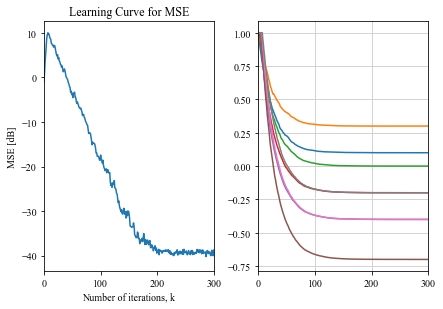

In [9]:
plot_learning_curve(300)

In [10]:
xi = np.mean(mse_avg[-500:])/1e-4-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)
print('approx number of iteration: %d ' % (-2/np.log10(1-2*mu)))

experiment Misadjustment: 0.1969
theory Misadjustment: 0.1905
approx number of iteration: 112 


In [11]:
# From the view of power
mse_max = max(mse_avg[:N+1])
print('approx number of iteration @power: %d ' % ( (-4 - np.log10(mse_max/2))/np.log10(1-4*mu) ) )

approx number of iteration @power: 129 


## spreed=20

### 全1 初始系数

In [12]:
ensemble = 100  # number of realizations within the ensemble
K = 2000  # number of iterations
b = np.asarray([0.1, 0.3, 0, -0.2, -0.4, -0.7, -0.4, -0.2])
a = np.asarray([1, -0.6894])
N = 8

rng = np.random.default_rng()
sigma2_v = 1 - a[-1] ** 2
sigma2_n = 1e-4

# mse_min = mse = np.zeros((ensemble, K))
mse_min_expectation = sigma2_n

mse = []
wk_rec = []
mu = mu20 /5
for j in range(ensemble):
    ex35 = LMS()
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    x = signal.lfilter([1], a, u)
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n) *rng.standard_normal(K)

    wk, ek = ex35.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

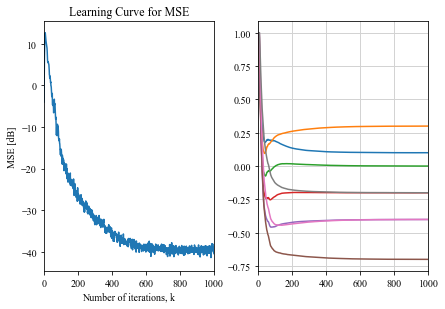

In [13]:
plot_learning_curve(1000)

In [14]:
xi = np.mean(mse_avg[-500:])/1e-4-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)
print('approx number of iteration: %d ' % (-2/np.log10(max(1-2*mu*(D20)))))

experiment Misadjustment: 0.1292
theory Misadjustment: 0.1141
approx number of iteration: 941 


### 注意

- 衰减为$100$，指的是正交空间中的初始系数与目标系数的相对误差中最大值为$1/100$。
- $941$ 看起来与图不符合，发现 $spreed =1$ 时差异太大，与 spreed 有很大关系。

### 疑问

- 特征值和目标系数之间的对应关系，旋转映射如何理解？
- 同一个目标系数的收敛速度是均值么？
- 不同系数的收敛情况一致么？

In [15]:
# 实际 差量
d_w = np.ones(N) - b
adjust = abs(d_w[-1] / (V20 @ d_w)[-1])

# 计算收敛最慢的系数迭代次数
print('average number of iteration: %d ' % np.mean( (-2 - np.log10(adjust))/np.log10(1-2*mu*(D20)) ) )

average number of iteration: 475 


In [16]:
tau_w = 1/2/mu/D20
print('tau_w: ', tau_w)
tau_e = tau_w/2
print('tau_e: ', tau_e)
print('expected number of iteration: ', round(max(tau_e)*np.log(100)))

tau_w:  [ 10.248   21.7521  44.3083  76.5728 114.2714 151.8634 183.6985 204.9605]
tau_e:  [  5.124   10.876   22.1541  38.2864  57.1357  75.9317  91.8492 102.4802]
expected number of iteration:  472


In [17]:
# From the view of power
mse_max = max(mse_avg[:N+1])
print('another number of iteration @power: %d ' % np.mean( (-4 - np.log10(mse_max/2) )/np.log10(1-4*mu*(D20))+N ))

another number of iteration @power: 579 


### 改变初始系数

In [18]:
ensemble = 100  # number of realizations within the ensemble
K = 2000  # number of iterations
b = np.asarray([0.1, 0.3, 0, -0.2, -0.4, -0.7, -0.4, -0.2])
a = np.asarray([1, -0.6894])
N = 8

rng = np.random.default_rng()
sigma2_v = 1 - a[-1] ** 2
sigma2_n = 1e-4

# mse_min = mse = np.zeros((ensemble, K))
mse_min_expectation = sigma2_n

mse = []
wk_rec = []
mu = mu20 /5
for j in range(ensemble):
    ex35 = LMS()
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    x = signal.lfilter([1], a, u)
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n) *rng.standard_normal(K)

    wk, ek = ex35.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': 10*np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

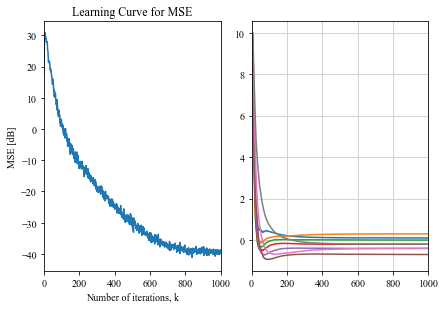

In [19]:
plot_learning_curve(1000)

In [20]:
d_w = 10*np.ones(N) - b
adjust = abs(d_w[-1] / (V20 @ d_w)[-1])
print('another number of iteration @coefficient: %d ' % np.mean( (-2-np.log10(adjust) )/np.log10(1-2*mu*(D20)) ))

another number of iteration @coefficient: 558 


In [21]:
mse_max = max(mse_avg[:N+1])
print('another number of iteration @power: %d ' % np.mean( (-4 - np.log10(mse_max/2) )/np.log10(1-4*mu*(D20))+N ))

another number of iteration @power: 788 


## spreed=80

### 全1 初始系数

In [22]:
ensemble = 100  # number of realizations within the ensemble
K = 2000  # number of iterations
b = np.asarray([0.1, 0.3, 0, -0.2, -0.4, -0.7, -0.4, -0.2])
a = np.asarray([1, -0.8702])
N = 8

rng = np.random.default_rng()
sigma2_v = 1 - a[-1] ** 2
sigma2_n = 1e-4

# mse_min = mse = np.zeros((ensemble, K))
mse_min_expectation = sigma2_n

mse = []
wk_rec = []
mu = mu80 /5
for j in range(ensemble):
    ex35 = LMS()
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    x = signal.lfilter([1], a, u)
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n) *rng.standard_normal(K)

    wk, ek = ex35.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

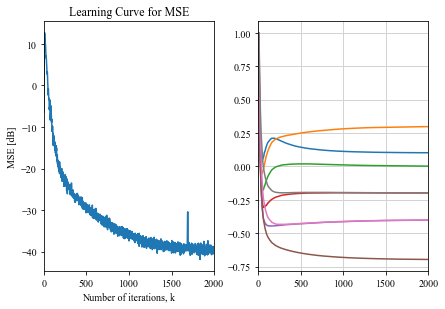

In [23]:
plot_learning_curve(2000)

In [24]:
xi = np.mean(mse_avg[-500:])/1e-4-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)

# From the view of coefficient
d_w = np.ones(N) - b
adjust = abs(d_w[-1] / (V80 @ d_w)[-1])
print('another number of iteration @coefficient: %d ' % np.mean( (-2 - np.log10(adjust) )/np.log10(1-2*mu*(D80)) ) )

# From the view of power
mse_max = max(mse_avg[:N+1])
print('another number of iteration @power: %d ' % np.mean( (-4 - np.log10(mse_max/2) )/np.log10(1-4*mu*(D80))+N ))

experiment Misadjustment: 0.2815
theory Misadjustment: 0.0892
another number of iteration @coefficient: 1270 
another number of iteration @power: 1804 


### 拟合 mse

another number of iteration @power: 1037 


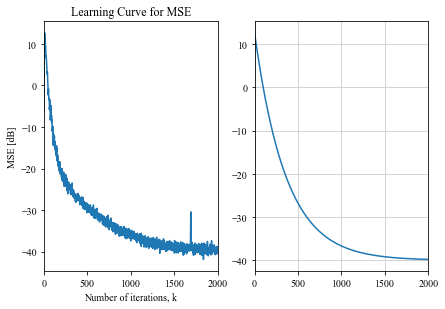

In [25]:
# From the fit curve of power 
e2db_avg = 10 * np.log10(mse_avg)
mse_db_max = max(e2db_avg[:N+1])
B = 10 * np.log10(mse_min_expectation)
A = mse_db_max - B

### 呈指数收敛的MSE曲线
tau_db = 1/np.mean(1/np.log10(1-4*mu*(D80)))
tau_db = tau_db/10*10
print('another number of iteration @power: %d ' % (1/tau_db*np.log(3/A)) )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(e2db_avg)
ax2.plot(A*np.exp(tau_db*np.arange(0,K)) + B )
ax2.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()
ax1.set_title('Learning Curve for MSE')
ax1.set_xlabel('Number of iterations, k')
ax1.set_ylabel('MSE [dB]')
ax1.set_xlim(0, K)
ax2.set_xlim(0, K)
plt.show()

### 改变初始系数

In [26]:
ensemble = 100  # number of realizations within the ensemble
K = 3000  # number of iterations
b = np.asarray([0.1, 0.3, 0, -0.2, -0.4, -0.7, -0.4, -0.2])
a = np.asarray([1, -0.8702])
N = 8

rng = np.random.default_rng()
sigma2_v = 1 - a[-1] ** 2
sigma2_n = 1e-4

# mse_min = mse = np.zeros((ensemble, K))
mse_min_expectation = sigma2_n

mse = []
wk_rec = []
mu = mu80 /5
for j in range(ensemble):
    ex35 = LMS()
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    x = signal.lfilter([1], a, u)
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n) *rng.standard_normal(K)

    wk, ek = ex35.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': 10*np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

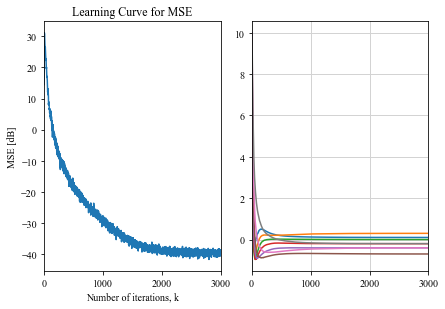

In [27]:
plot_learning_curve(3000)

In [28]:
xi = np.mean(mse_avg[-500:])/1e-4-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)

# From the view of coefficient
d_w = 10*np.ones(N) - b
adjust = abs(d_w[-1] / (V80 @ d_w)[-1])
print('another number of iteration @coefficient: %d ' % np.mean( (-2 - np.log10(adjust) )/np.log10(1-2*mu*(D80)) ) )

# From the view of power
mse_max = max(mse_avg[:N+1])
print('another number of iteration @power: %d ' % np.mean( (-4 - np.log10(mse_max/2) )/np.log10(1-4*mu*(D80))+N ))

experiment Misadjustment: 0.1138
theory Misadjustment: 0.0892
another number of iteration @coefficient: 1313 
another number of iteration @power: 2475 


### 拟合 mse

another number of iteration @power: 1637 


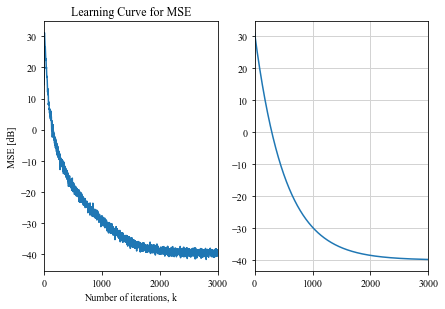

In [29]:
# From the fit curve of power
e2db_avg = 10 * np.log10(mse_avg)
mse_db_max = max(e2db_avg[:N+1])
B = 10 * np.log10(mse_min_expectation)
A = mse_db_max - B

### 呈指数收敛的MSE曲线
tau_db = 1/np.mean(1/np.log10(1-4*mu*(D80)))
tau_db = tau_db/10*7
print('another number of iteration @power: %d ' % (1/tau_db*np.log(3/A)) )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(e2db_avg)
ax2.plot(A*np.exp(tau_db*np.arange(0,K)) + B )
ax2.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()
ax1.set_title('Learning Curve for MSE')
ax1.set_xlabel('Number of iterations, k')
ax1.set_ylabel('MSE [dB]')
ax1.set_xlim(0, K)
ax2.set_xlim(0, K)
plt.show()

## 一点结论

- spread=1 时，mse 的 db曲线呈线性收敛。
- spread=1 时，系数的迭代次数为不足估计。
- spread=1 时，mse 的迭代次数与 系数的相近。
- spreed较大时，mse曲线呈指数函数收敛。
- spreed较大时，mse 及系数的收敛明确受到初值的影响。
- spreed较大时，mse 的迭代次数为 过估计。
- spreed较大时，mse 的收敛 和 系数的收敛需要区别开，由于系数为不足估计，而mse 为过估计，可结合来看。